In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns

# Analysis
import time
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats
import glob
import os 

import metpy.calc as mpc
from metpy.units import units
from metpy.plots import Hodograph, SkewT

import warnings
warnings.filterwarnings('ignore')



In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds


In [3]:
'''
Define a function to get the height of the PBL as the level with maximum d(var)/dz. 
Inputs:  A dataset with CAM output ('DS') and the variable to differentiate ('pbl_var')
Outputs: An array with boundary layer depth
'''
def PBLHasMaxDZ(DS, pbl_var): 
    # Convert HMGcamDS_all to height (nabbed from Rich's script)
    p0 = DS['P0'].values[0]
    
    plevm = DS['hyam']*p0 + DS['hybm']*DS['PS'].isel(lat=0,lon=0) # Mid level
    plevm.attrs['units'] = "Pa"

    # Height with standard atmosphere
    zlevm      = plevm
    zlevm_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm)) # Units of [m] after multiplied 
    zlevm      = plevm.copy(deep=True)
    zlevm[:,:] = zlevm_vals
    
    pvar        = DS[pbl_var].isel(lat=0,lon=0)
    pvar['lev'] = zlevm[0,:].values
    dvardz      = pvar.differentiate("lev") # Find field gradient wrt HEIGHT!

    dvardz.loc[:,200:]   = 0.  # Restrict to a specificheight region
    dvardz.loc[:,:3000.] = 0

    nT = np.shape(dvardz)[0]
    PBLdepth = np.full([nT], np.nan)

    for iT in range(nT):
        iLevs  = np.where((zlevm[iT,:]>=200) & (zlevm[iT,:]<=3000))[0]
        maxLev = np.where(dvardz[iT,iLevs]==np.nanmax(dvardz[iT,iLevs]))[0]
        PBLdepth[iT] = zlevm[iT,iLevs[maxLev[0]]]
    
    return PBLdepth

In [4]:
def interpolateToPressure_v2(DS, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DS.P0.values[0]/100        # mb

    # Pull out hya/hyb profiles 
    hyam = DS.hyam.values[0,:]
    hybm = DS.hybm.values[0,:]
    hyai = DS.hyai.values[0,:]
    hybi = DS.hybi.values[0,:]

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut


## Read in data 

In [5]:
dataDir = '/glade/scratch/mdfowler/archive/'


# caseList_HMG = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMGens_start06092015_pert00_3wk',
#                            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMGens_start06092015_pert01_3wk',
#                            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMGens_start06092015_pert02_3wk',
#                            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMGens_start06092015_pert03_3wk',
#                            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMGens_start06092015_pert04_3wk'])

# caseList_HTG = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens_start06092015_pert00_3wk',
#                            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens_start06092015_pert01_3wk',
#                            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens_start06092015_pert02_3wk',
#                            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens_start06092015_pert03_3wk',
#                            'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens_start06092015_pert04_3wk'])

caseList_HMG = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMGens_start08072015_pert00_3wk',
                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMGens_start08072015_pert01_3wk',
                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMGens_start08072015_pert02_3wk',
                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMGens_start08072015_pert03_3wk',
                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMGens_start08072015_pert04_3wk'])

caseList_HTG = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens_start08072015_pert00_3wk',
                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens_start08072015_pert01_3wk',
                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens_start08072015_pert02_3wk',
                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens_start08072015_pert03_3wk',
                           'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens_start08072015_pert04_3wk'])

## Extra vars I want, but they're on the h0 files instead of the h1 files (same time step, just different stream) 
addVars = np.asarray(['SWCF','LWCF','TS','CLOUD','CONCLD','FSNS','FLNS','PS','QFLX','QREFHT','QRL','QRS',
                      'U10','CLDHGH','CLDLIQ','TMQ'])

pertCount = 0
for iPert in range(len(caseList_HMG)): 
#     hmgFile = dataDir+caseList_HMG[iFile]+'/atm/hist/'+caseList_HMG[iFile]+'.cam.h1.2015-06-09-18060.nc'
#     htgFile = dataDir+caseList_HTG[iFile]+'/atm/hist/'+caseList_HTG[iFile]+'.cam.h1.2015-06-09-18060.nc'    
    
#     hmgFileCLM = dataDir+caseList_HMG[iFile]+'/lnd/hist/'+caseList_HMG[iFile]+'.clm2.h0.2015-06-09-18060.nc'
#     htgFileCLM = dataDir+caseList_HTG[iFile]+'/lnd/hist/'+caseList_HTG[iFile]+'.clm2.h0.2015-06-09-18060.nc'  
    
#     hmgFile_h0 = dataDir+caseList_HMG[iFile]+'/atm/hist/'+caseList_HMG[iFile]+'.cam.h0.2015-06-09-18060.nc'
#     htgFile_h0 = dataDir+caseList_HTG[iFile]+'/atm/hist/'+caseList_HTG[iFile]+'.cam.h0.2015-06-09-18060.nc'  

    ## Get list of files within each (pertlim) case 
    listFilesHMG_camh1 = np.sort(glob.glob(dataDir+caseList_HMG[iPert]+'/atm/hist/*h1*'))
    listFilesHMG_camh0 = np.sort(glob.glob(dataDir+caseList_HMG[iPert]+'/atm/hist/*h0*'))
    
    listFilesHTG_camh1 = np.sort(glob.glob(dataDir+caseList_HTG[iPert]+'/atm/hist/*h1*'))
    listFilesHTG_camh0 = np.sort(glob.glob(dataDir+caseList_HTG[iPert]+'/atm/hist/*h0*'))
    
    listFilesHMG_clmh0 = np.sort(glob.glob(dataDir+caseList_HMG[iPert]+'/lnd/hist/*h0*'))
    listFilesHTG_clmh0 = np.sort(glob.glob(dataDir+caseList_HTG[iPert]+'/lnd/hist/*h0*'))
    
    ## Loop over files and read into larger case array 
    fileCount = 0
    for iFile in range(len(listFilesHMG_camh1)): 
        with xr.open_dataset(listFilesHMG_camh1[iFile], decode_times=False) as hmgDS: 
            hmgDS         = cesm_correct_time(hmgDS)
            hmgDS['time'] = hmgDS.indexes['time'].to_datetimeindex() 
        with xr.open_dataset(listFilesHTG_camh1[iFile], decode_times=False) as htgDS: 
            htgDS         = cesm_correct_time(htgDS)
            htgDS['time'] = htgDS.indexes['time'].to_datetimeindex()

        with xr.open_dataset(listFilesHMG_clmh0[iFile], decode_times=True) as clm_hmgDS: 
                clm_hmgDS['time'] = hmgDS['time']
        with xr.open_dataset(listFilesHTG_clmh0[iFile], decode_times=True) as clm_htgDS: 
                clm_htgDS['time'] = htgDS['time']    

        ## Add variables as needed (some are on h0 file stream)
        for iVar in range(len(addVars)):
            varHMG = xr.open_dataset(listFilesHMG_camh0[iFile])[addVars[iVar]]
            varHMG['time'] = hmgDS['time']

            varHTG = xr.open_dataset(listFilesHTG_camh0[iFile])[addVars[iVar]]
            varHTG['time'] = htgDS['time']

            hmgDS = xr.merge([hmgDS, varHMG])
            htgDS = xr.merge([htgDS, varHTG]) 
        
        # Build larger array 
        if fileCount==0:
            hmg_all      = hmgDS
            htg_all      = htgDS
            clmHMG_all   = clm_hmgDS
            clmHTG_all   = clm_htgDS
        else: 
            hmg_all      = xr.concat([hmg_all,     hmgDS],      dim='time')
            htg_all      = xr.concat([htg_all,     htgDS],      dim='time')
            clmHMG_all   = xr.concat([clmHMG_all,  clm_hmgDS],  dim='time', data_vars='minimal')
            clmHTG_all   = xr.concat([clmHTG_all,  clm_htgDS],  dim='time', data_vars='minimal')
            
        fileCount = fileCount+1
        
    ## Combine into larger HTG or HMG arrays for all pertlim experiments 
    hmg_all      = hmg_all.assign_coords({"pertlim": iPert})
    htg_all      = htg_all.assign_coords({"pertlim": iPert})
    clmHMG_all   = clmHMG_all.assign_coords({"pertlim": iPert})
    clmHTG_all   = clmHTG_all.assign_coords({"pertlim": iPert})    

    if pertCount==0: 
        hmgDS_pert = hmg_all
        htgDS_pert = htg_all 

        clm_hmgDS_pert = clmHMG_all
        clm_htgDS_pert = clmHTG_all 
    else: 
        hmgDS_pert = xr.concat([hmgDS_pert, hmg_all], "pert")
        htgDS_pert = xr.concat([htgDS_pert, htg_all], "pert")

        clm_hmgDS_pert = xr.concat([clm_hmgDS_pert, clmHMG_all], "pert")
        clm_htgDS_pert = xr.concat([clm_htgDS_pert, clmHTG_all], "pert")

    del hmg_all
    del htg_all 
    del clmHMG_all
    del clmHTG_all
    pertCount=pertCount+1


In [6]:
## Convert to local times...
hmgDS_local = hmgDS_pert.copy(deep=True)
htgDS_local = htgDS_pert.copy(deep=True)
clm_hmgDS_local = clm_hmgDS_pert.copy(deep=True)
clm_htgDS_local = clm_htgDS_pert.copy(deep=True)

# Confirmed that all the times are identical, so using the same local time arrays
localTimes = hmgDS_pert['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
hmgDS_local    = hmgDS_local.assign_coords({"time": localTimes})
htgDS_local    = htgDS_local.assign_coords({"time": localTimes})

clm_hmgDS_local    = clm_hmgDS_local.assign_coords({"time": localTimes})
clm_htgDS_local    = clm_htgDS_local.assign_coords({"time": localTimes})

print('First four times in UTC:\n',   hmgDS_pert.time.values[0:5])
print('First four times in local:\n', hmgDS_local.time.values[0:5])


First four times in UTC:
 ['2015-08-07T05:01:00.000000000' '2015-08-07T05:03:30.000000000'
 '2015-08-07T05:08:30.000000000' '2015-08-07T05:13:30.000000000'
 '2015-08-07T05:18:30.000000000']
First four times in local:
 ['2015-08-07T00:01:00.000000000' '2015-08-07T00:03:30.000000000'
 '2015-08-07T00:08:30.000000000' '2015-08-07T00:13:30.000000000'
 '2015-08-07T00:18:30.000000000']


(16654.0, 16662.0)

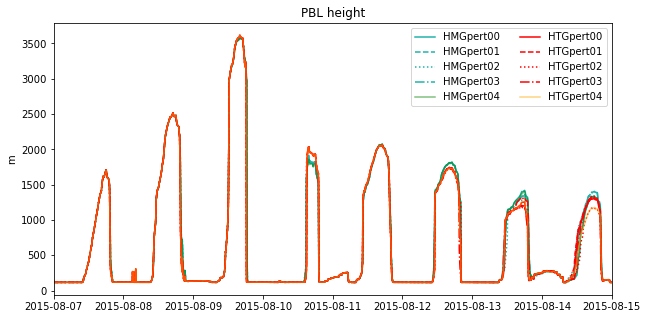

In [24]:
fig,axs = plt.subplots(1,1, figsize=(10,5))

varPlot = 'PBLH'

axs.plot(hmgDS_local.time.values, hmgDS_local[varPlot].values[0,:,0,0], color='lightseagreen',linestyle='-',  label='HMGpert00')
axs.plot(hmgDS_local.time.values, hmgDS_local[varPlot].values[1,:,0,0], color='lightseagreen',linestyle='--', label='HMGpert01')
axs.plot(hmgDS_local.time.values, hmgDS_local[varPlot].values[2,:,0,0], color='lightseagreen',linestyle=':',  label='HMGpert02')
axs.plot(hmgDS_local.time.values, hmgDS_local[varPlot].values[3,:,0,0], color='lightseagreen',linestyle='-.', label='HMGpert03')
axs.plot(hmgDS_local.time.values, hmgDS_local[varPlot].values[4,:,0,0], color='green',linestyle='-',alpha=0.5, label='HMGpert04')

axs.plot(htgDS_local.time.values, htgDS_local[varPlot].values[0,:,0,0], color='red',linestyle='-',  label='HTGpert00')
axs.plot(htgDS_local.time.values, htgDS_local[varPlot].values[1,:,0,0], color='red',linestyle='--', label='HTGpert01')
axs.plot(htgDS_local.time.values, htgDS_local[varPlot].values[2,:,0,0], color='red',linestyle=':',  label='HTGpert02')
axs.plot(htgDS_local.time.values, htgDS_local[varPlot].values[3,:,0,0], color='red',linestyle='-.', label='HTGpert03')
axs.plot(htgDS_local.time.values, htgDS_local[varPlot].values[4,:,0,0], color='orange',linestyle='-',alpha=0.5, label='HTGpert04')

axs.legend(ncol=2)
axs.set_ylabel(hmgDS_pert[varPlot].units)
axs.set_title(hmgDS_pert[varPlot].long_name)

axs.set_xlim([datetime.date(2015,8,7), datetime.date(2015,8,15)])
# axs.set_xlim([datetime.date(2015,6,9), datetime.date(2015,6,17)])


(16654.0, 16662.0)

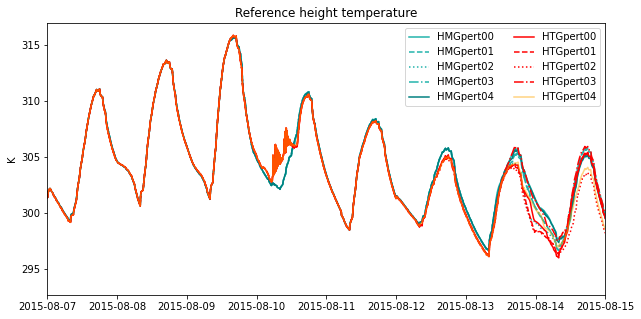

In [23]:
fig,axs = plt.subplots(1,1, figsize=(10,5))

varPlot='TREFHT'

axs.plot(hmgDS_local.time.values, hmgDS_local[varPlot].values[0,:,0,0], color='lightseagreen',linestyle='-',  label='HMGpert00')
axs.plot(hmgDS_local.time.values, hmgDS_local[varPlot].values[1,:,0,0], color='lightseagreen',linestyle='--', label='HMGpert01')
axs.plot(hmgDS_local.time.values, hmgDS_local[varPlot].values[2,:,0,0], color='lightseagreen',linestyle=':',  label='HMGpert02')
axs.plot(hmgDS_local.time.values, hmgDS_local[varPlot].values[3,:,0,0], color='lightseagreen',linestyle='-.', label='HMGpert03')
axs.plot(hmgDS_local.time.values, hmgDS_local[varPlot].values[4,:,0,0], color='teal',linestyle='-', label='HMGpert04')

axs.plot(htgDS_local.time.values, htgDS_local[varPlot].values[0,:,0,0], color='red',linestyle='-',  label='HTGpert00')
axs.plot(htgDS_local.time.values, htgDS_local[varPlot].values[1,:,0,0], color='red',linestyle='--', label='HTGpert01')
axs.plot(htgDS_local.time.values, htgDS_local[varPlot].values[2,:,0,0], color='red',linestyle=':',  label='HTGpert02')
axs.plot(htgDS_local.time.values, htgDS_local[varPlot].values[3,:,0,0], color='red',linestyle='-.', label='HTGpert03')
axs.plot(htgDS_local.time.values, htgDS_local[varPlot].values[4,:,0,0], color='orange',linestyle='-',alpha=0.5, label='HTGpert04')

axs.legend(ncol=2)
axs.set_ylabel(hmgDS_pert[varPlot].units)
axs.set_title(hmgDS_pert[varPlot].long_name)

axs.set_xlim([datetime.date(2015,8,7), datetime.date(2015,8,15)])
# axs.set_xlim([datetime.date(2015,6,9), datetime.date(2015,6,17)])


Text(0.5, 1.0, 'Surface sensible heat flux')

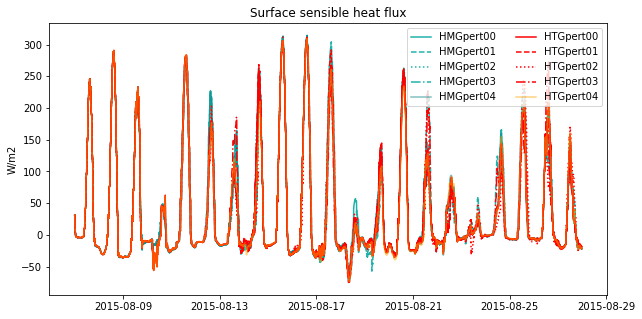

In [9]:
fig,axs = plt.subplots(1,1, figsize=(10,5))

varPlot='SHFLX'

axs.plot(hmgDS_local.time.values, hmgDS_local[varPlot].values[0,:,0,0], color='lightseagreen',linestyle='-',  label='HMGpert00')
axs.plot(hmgDS_local.time.values, hmgDS_local[varPlot].values[1,:,0,0], color='lightseagreen',linestyle='--', label='HMGpert01')
axs.plot(hmgDS_local.time.values, hmgDS_local[varPlot].values[2,:,0,0], color='lightseagreen',linestyle=':',  label='HMGpert02')
axs.plot(hmgDS_local.time.values, hmgDS_local[varPlot].values[3,:,0,0], color='lightseagreen',linestyle='-.', label='HMGpert03')
axs.plot(hmgDS_local.time.values, hmgDS_local[varPlot].values[4,:,0,0], color='teal',linestyle='-',alpha=0.5, label='HMGpert04')

axs.plot(htgDS_local.time.values, htgDS_local[varPlot].values[0,:,0,0], color='red',linestyle='-',  label='HTGpert00')
axs.plot(htgDS_local.time.values, htgDS_local[varPlot].values[1,:,0,0], color='red',linestyle='--', label='HTGpert01')
axs.plot(htgDS_local.time.values, htgDS_local[varPlot].values[2,:,0,0], color='red',linestyle=':',  label='HTGpert02')
axs.plot(htgDS_local.time.values, htgDS_local[varPlot].values[3,:,0,0], color='red',linestyle='-.', label='HTGpert03')
axs.plot(htgDS_local.time.values, htgDS_local[varPlot].values[4,:,0,0], color='orange',linestyle='-',alpha=0.5, label='HTGpert04')


axs.legend(ncol=2)
axs.set_ylabel(hmgDS_pert[varPlot].units)
axs.set_title(hmgDS_pert[varPlot].long_name)

# axs.set_xlim([datetime.date(2015,8,7), datetime.date(2015,8,15)])
# axs.set_xlim([datetime.date(2015,6,9), datetime.date(2015,6,16)])


Text(0.5, 1.0, 'Vertically-integrated total cloud')

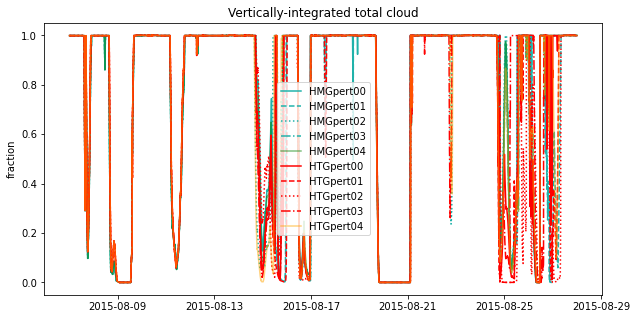

In [10]:
fig,axs = plt.subplots(1,1, figsize=(10,5))

varPlot='CLDTOT'

axs.plot(hmgDS_local.time.values, hmgDS_local[varPlot].values[0,:,0,0], color='lightseagreen',linestyle='-',  label='HMGpert00')
axs.plot(hmgDS_local.time.values, hmgDS_local[varPlot].values[1,:,0,0], color='lightseagreen',linestyle='--', label='HMGpert01')
axs.plot(hmgDS_local.time.values, hmgDS_local[varPlot].values[2,:,0,0], color='lightseagreen',linestyle=':',  label='HMGpert02')
axs.plot(hmgDS_local.time.values, hmgDS_local[varPlot].values[3,:,0,0], color='lightseagreen',linestyle='-.', label='HMGpert03')
axs.plot(hmgDS_local.time.values, hmgDS_local[varPlot].values[4,:,0,0], color='green',linestyle='-',alpha=0.5, label='HMGpert04')

axs.plot(htgDS_local.time.values, htgDS_local[varPlot].values[0,:,0,0], color='red',linestyle='-',  label='HTGpert00')
axs.plot(htgDS_local.time.values, htgDS_local[varPlot].values[1,:,0,0], color='red',linestyle='--', label='HTGpert01')
axs.plot(htgDS_local.time.values, htgDS_local[varPlot].values[2,:,0,0], color='red',linestyle=':',  label='HTGpert02')
axs.plot(htgDS_local.time.values, htgDS_local[varPlot].values[3,:,0,0], color='red',linestyle='-.', label='HTGpert03')
axs.plot(htgDS_local.time.values, htgDS_local[varPlot].values[4,:,0,0], color='orange',linestyle='-',alpha=0.5, label='HTGpert04')


axs.legend()
axs.set_ylabel(hmgDS_pert[varPlot].units)
axs.set_title(hmgDS_pert[varPlot].long_name)

# axs.set_xlim([datetime.date(2015,8,7), datetime.date(2015,8,15)])
# axs.set_xlim([datetime.date(2015,6,9), datetime.date(2015,6,16)])


(16654.0, 16662.0)

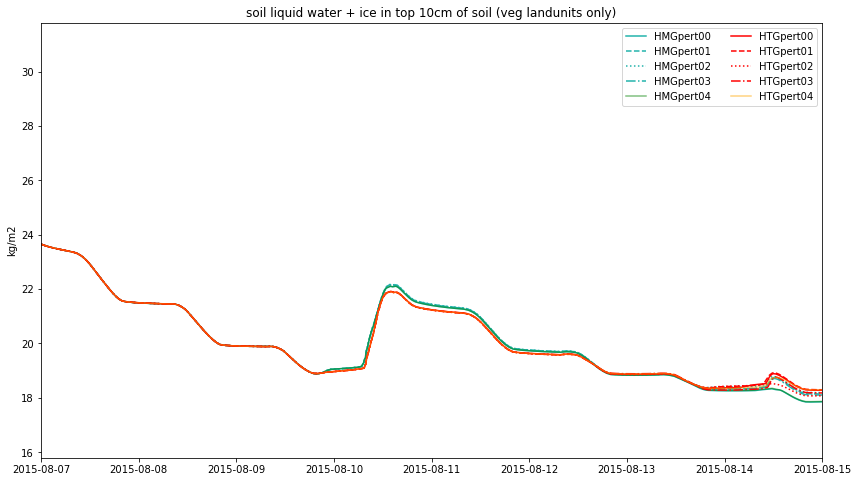

In [22]:
fig,axs = plt.subplots(1,1, figsize=(14,8))

varPlot = 'SOILWATER_10CM'

axs.plot(clm_hmgDS_local.time.values, clm_hmgDS_local[varPlot].values[0,:], color='lightseagreen',linestyle='-',  label='HMGpert00')
axs.plot(clm_hmgDS_local.time.values, clm_hmgDS_local[varPlot].values[1,:], color='lightseagreen',linestyle='--', label='HMGpert01')
axs.plot(clm_hmgDS_local.time.values, clm_hmgDS_local[varPlot].values[2,:], color='lightseagreen',linestyle=':',  label='HMGpert02')
axs.plot(clm_hmgDS_local.time.values, clm_hmgDS_local[varPlot].values[3,:], color='lightseagreen',linestyle='-.', label='HMGpert03')
axs.plot(clm_hmgDS_local.time.values, clm_hmgDS_local[varPlot].values[4,:], color='green',linestyle='-', alpha=0.5, label='HMGpert04')

axs.plot(clm_htgDS_local.time.values, clm_htgDS_local[varPlot].values[0,:], color='red',linestyle='-',  label='HTGpert00')
axs.plot(clm_htgDS_local.time.values, clm_htgDS_local[varPlot].values[1,:], color='red',linestyle='--', label='HTGpert01')
axs.plot(clm_htgDS_local.time.values, clm_htgDS_local[varPlot].values[2,:], color='red',linestyle=':',  label='HTGpert02')
axs.plot(clm_htgDS_local.time.values, clm_htgDS_local[varPlot].values[3,:], color='red',linestyle='-.', label='HTGpert03')
axs.plot(clm_htgDS_local.time.values, clm_htgDS_local[varPlot].values[4,:], color='orange',linestyle='-',alpha=0.5, label='HTGpert04')

axs.legend(ncol=2)
axs.set_ylabel(clm_htgDS_local[varPlot].units)
axs.set_title(clm_htgDS_local[varPlot].long_name)

axs.set_xlim([datetime.date(2015,8,7), datetime.date(2015,8,15)])
# axs.set_xlim([datetime.date(2015,6,9), datetime.date(2015,6,17)])


(16654.0, 16662.0)

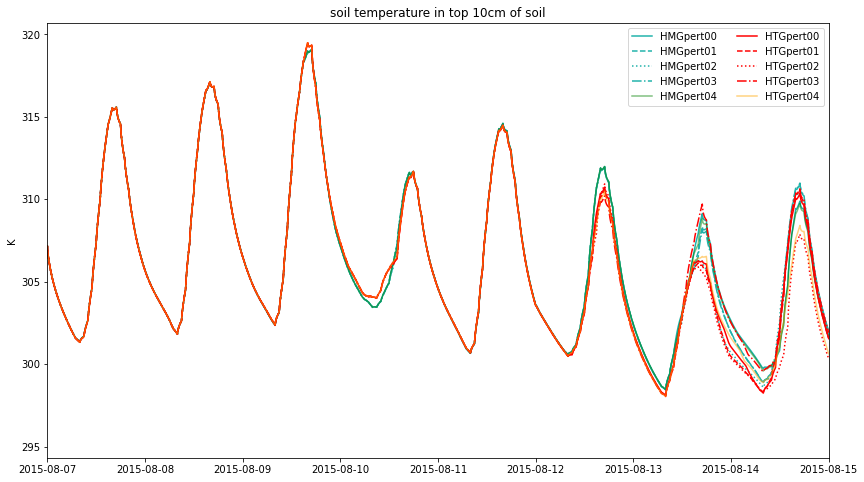

In [21]:
fig,axs = plt.subplots(1,1, figsize=(14,8))

varPlot = 'TSOI_10CM'

axs.plot(clm_hmgDS_local.time.values, clm_hmgDS_local[varPlot].values[0,:], color='lightseagreen',linestyle='-',  label='HMGpert00')
axs.plot(clm_hmgDS_local.time.values, clm_hmgDS_local[varPlot].values[1,:], color='lightseagreen',linestyle='--', label='HMGpert01')
axs.plot(clm_hmgDS_local.time.values, clm_hmgDS_local[varPlot].values[2,:], color='lightseagreen',linestyle=':',  label='HMGpert02')
axs.plot(clm_hmgDS_local.time.values, clm_hmgDS_local[varPlot].values[3,:], color='lightseagreen',linestyle='-.', label='HMGpert03')
axs.plot(clm_hmgDS_local.time.values, clm_hmgDS_local[varPlot].values[4,:], color='green',linestyle='-',alpha=0.5, label='HMGpert04')

axs.plot(clm_htgDS_local.time.values, clm_htgDS_local[varPlot].values[0,:], color='red',linestyle='-',  label='HTGpert00')
axs.plot(clm_htgDS_local.time.values, clm_htgDS_local[varPlot].values[1,:], color='red',linestyle='--', label='HTGpert01')
axs.plot(clm_htgDS_local.time.values, clm_htgDS_local[varPlot].values[2,:], color='red',linestyle=':',  label='HTGpert02')
axs.plot(clm_htgDS_local.time.values, clm_htgDS_local[varPlot].values[3,:], color='red',linestyle='-.', label='HTGpert03')
axs.plot(clm_htgDS_local.time.values, clm_htgDS_local[varPlot].values[4,:], color='orange',linestyle='-',alpha=0.5, label='HTGpert04')

axs.legend(ncol=2)
axs.set_ylabel(clm_htgDS_local[varPlot].units)
axs.set_title(clm_htgDS_local[varPlot].long_name)

axs.set_xlim([datetime.date(2015,8,7), datetime.date(2015,8,15)])
# axs.set_xlim([datetime.date(2015,6,9), datetime.date(2015,6,16)])


(16654.0, 16662.0)

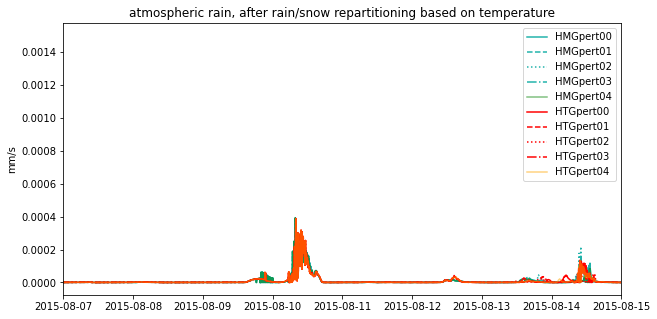

In [20]:
fig,axs = plt.subplots(1,1, figsize=(10,5))

varPlot = 'RAIN'

axs.plot(clm_hmgDS_local.time.values, clm_hmgDS_local[varPlot].values[0,:], color='lightseagreen',linestyle='-',  label='HMGpert00')
axs.plot(clm_hmgDS_local.time.values, clm_hmgDS_local[varPlot].values[1,:], color='lightseagreen',linestyle='--', label='HMGpert01')
axs.plot(clm_hmgDS_local.time.values, clm_hmgDS_local[varPlot].values[2,:], color='lightseagreen',linestyle=':',  label='HMGpert02')
axs.plot(clm_hmgDS_local.time.values, clm_hmgDS_local[varPlot].values[3,:], color='lightseagreen',linestyle='-.', label='HMGpert03')
axs.plot(clm_hmgDS_local.time.values, clm_hmgDS_local[varPlot].values[4,:], color='green',linestyle='-',alpha=0.5, label='HMGpert04')

axs.plot(clm_htgDS_local.time.values, clm_htgDS_local[varPlot].values[0,:], color='red',linestyle='-',  label='HTGpert00')
axs.plot(clm_htgDS_local.time.values, clm_htgDS_local[varPlot].values[1,:], color='red',linestyle='--', label='HTGpert01')
axs.plot(clm_htgDS_local.time.values, clm_htgDS_local[varPlot].values[2,:], color='red',linestyle=':',  label='HTGpert02')
axs.plot(clm_htgDS_local.time.values, clm_htgDS_local[varPlot].values[3,:], color='red',linestyle='-.', label='HTGpert03')
axs.plot(clm_htgDS_local.time.values, clm_htgDS_local[varPlot].values[4,:], color='orange',linestyle='-',alpha=0.5, label='HTGpert04')

axs.legend()
axs.set_ylabel(clm_htgDS_local[varPlot].units)
axs.set_title(clm_htgDS_local[varPlot].long_name)

axs.set_xlim([datetime.date(2015,8,7), datetime.date(2015,8,15)])
# axs.set_xlim([datetime.date(2015,6,9), datetime.date(2015,6,17)])


(16654.0, 16662.0)

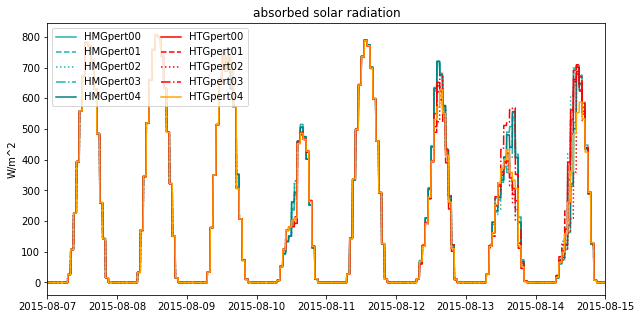

In [19]:
fig,axs = plt.subplots(1,1, figsize=(10,5))

varPlot = 'FSA'

axs.plot(clm_hmgDS_local.time.values, clm_hmgDS_local[varPlot].values[0,:], color='lightseagreen',linestyle='-',  label='HMGpert00')
axs.plot(clm_hmgDS_local.time.values, clm_hmgDS_local[varPlot].values[1,:], color='lightseagreen',linestyle='--', label='HMGpert01')
axs.plot(clm_hmgDS_local.time.values, clm_hmgDS_local[varPlot].values[2,:], color='lightseagreen',linestyle=':',  label='HMGpert02')
axs.plot(clm_hmgDS_local.time.values, clm_hmgDS_local[varPlot].values[3,:], color='lightseagreen',linestyle='-.', label='HMGpert03')
axs.plot(clm_hmgDS_local.time.values, clm_hmgDS_local[varPlot].values[4,:], color='teal',linestyle='-', label='HMGpert04')

axs.plot(clm_htgDS_local.time.values, clm_htgDS_local[varPlot].values[0,:], color='red',linestyle='-',  label='HTGpert00')
axs.plot(clm_htgDS_local.time.values, clm_htgDS_local[varPlot].values[1,:], color='red',linestyle='--', label='HTGpert01')
axs.plot(clm_htgDS_local.time.values, clm_htgDS_local[varPlot].values[2,:], color='red',linestyle=':',  label='HTGpert02')
axs.plot(clm_htgDS_local.time.values, clm_htgDS_local[varPlot].values[3,:], color='red',linestyle='-.', label='HTGpert03')
axs.plot(clm_htgDS_local.time.values, clm_htgDS_local[varPlot].values[4,:], color='orange',linestyle='-', label='HTGpert04')

axs.legend(ncol=2, loc='upper left')
axs.set_ylabel(clm_htgDS_local[varPlot].units)
axs.set_title(clm_htgDS_local[varPlot].long_name)

axs.set_xlim([datetime.date(2015,8,7), datetime.date(2015,8,15)])
# axs.set_xlim([datetime.date(2015,6,9), datetime.date(2015,6,17)])


Text(0.5, 1.0, 'reflected solar radiation')

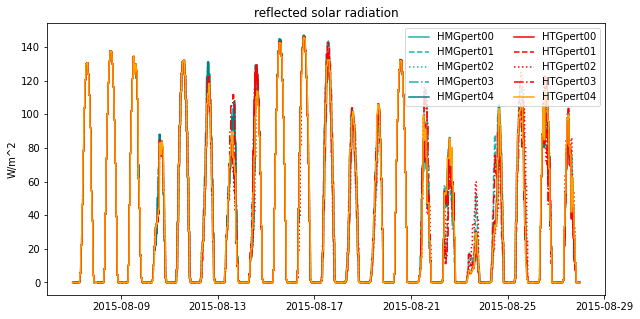

In [15]:
fig,axs = plt.subplots(1,1, figsize=(10,5))

varPlot = 'FSR'

axs.plot(clm_hmgDS_local.time.values, clm_hmgDS_local[varPlot].values[0,:], color='lightseagreen',linestyle='-',  label='HMGpert00')
axs.plot(clm_hmgDS_local.time.values, clm_hmgDS_local[varPlot].values[1,:], color='lightseagreen',linestyle='--', label='HMGpert01')
axs.plot(clm_hmgDS_local.time.values, clm_hmgDS_local[varPlot].values[2,:], color='lightseagreen',linestyle=':',  label='HMGpert02')
axs.plot(clm_hmgDS_local.time.values, clm_hmgDS_local[varPlot].values[3,:], color='lightseagreen',linestyle='-.', label='HMGpert03')
axs.plot(clm_hmgDS_local.time.values, clm_hmgDS_local[varPlot].values[4,:], color='teal',linestyle='-', label='HMGpert04')

axs.plot(clm_htgDS_local.time.values, clm_htgDS_local[varPlot].values[0,:], color='red',linestyle='-',  label='HTGpert00')
axs.plot(clm_htgDS_local.time.values, clm_htgDS_local[varPlot].values[1,:], color='red',linestyle='--', label='HTGpert01')
axs.plot(clm_htgDS_local.time.values, clm_htgDS_local[varPlot].values[2,:], color='red',linestyle=':',  label='HTGpert02')
axs.plot(clm_htgDS_local.time.values, clm_htgDS_local[varPlot].values[3,:], color='red',linestyle='-.', label='HTGpert03')
axs.plot(clm_htgDS_local.time.values, clm_htgDS_local[varPlot].values[4,:], color='orange',linestyle='-', label='HTGpert04')

axs.legend(ncol=2)
axs.set_ylabel(clm_htgDS_local[varPlot].units)
axs.set_title(clm_htgDS_local[varPlot].long_name)

# axs.set_xlim([datetime.date(2015,8,7), datetime.date(2015,8,15)])
# axs.set_xlim([datetime.date(2015,6,9), datetime.date(2015,6,17)])


## Plot timeseries as differences

## Get every four dates

In [4]:
saveDir = '/glade/work/mdfowler/CLASP/histData/processedData/'

realSfcHMG = pickle.load( open( saveDir+"realSfc_HMG_rtpthlponly_relaxTlongTau_freeSfcT.p" , "rb") )



In [21]:
from datetime import date
dayStart = date(2015,6,1) 
dayEnd   = date(2015,8,31) 


dateArr = pd.date_range(dayStart,dayEnd-timedelta(days=1),freq='d')


In [23]:
offset = 0 

for i in range(23):
    print(dateArr[offset].month, '  ', dateArr[offset].day)
    offset = offset+4
    

6    1
6    5
6    9
6    13
6    17
6    21
6    25
6    29
7    3
7    7
7    11
7    15
7    19
7    23
7    27
7    31
8    4
8    8
8    12
8    16
8    20
8    24
8    28
